# AdaBoost
The following code implements the AdaBoost class

In [28]:
%matplotlib notebook
import ipython_notebook_importer
from sklearn.tree import DecisionTreeClassifier
import sparsipy
import numpy as np
import matplotlib.pyplot as plt
import copy

class AdaBoost:

    def __init__(self, debug=False, visualize=False, compute_margins = False, print_progress=False, color='-g'):
        self.debug           = debug
        self.visualize       = visualize
        self.alphas = []
        self.estimators = []
        self.color = color
        self.minimal_margins = []
        self.compute_margins = compute_margins
        self.print_progress = print_progress
        self.force_silent    = False
        
        if self.visualize: 
            self.fig, (self.ax_margins, self.ax_exp_loss) = plt.subplots(1, 2, figsize=(10,5))
            self.minimal_margins = []
            self.exp_loss = []
            self.xs = []
            self.compute_margins = True

    def do_print_progress(self, i, remaining, last=False):
        # we have 80 '=', compute percentages
        percentages = i / remaining
        done_num = int(percentages * 60)
        space_num = 60 - done_num-2
        
        print("\r" + " "*80, end='')
        progress_string = "[" + "="*done_num + ">" + " "*space_num + "]\t" + str(round(percentages*100, 3)) + "%"
        
        print("\r" + progress_string, end='')
                  
        if last:
            print("\r" + " "*120, end='')
            print("\r[" + "="*done_num + ">]\tDONE!\t", flush=True) 
            
            
    
    def fit(self, X, y, T):
        n, d = X.shape
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
        
        self.sample_weight = np.ones(n) / n # start with uniform distribution
        self.step_to(X, y, T)
        

    def step(self, X, y):
        # Learn weak guy on weighted data 
        h_t  = DecisionTreeClassifier(max_depth=1) # 1 => decision stump?
        h_t.fit(X, y, sample_weight=self.sample_weight)
        
        # Compute error of current hypothesis
        eps_t = 1 - h_t.score(X, y, sample_weight=self.sample_weight)

        # Compute weight of current hypothesis given its error
        alpha_t = 1/2 * np.log((1-eps_t)/eps_t)

        # Add weight and weak classifier to list
        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        # Update sample weight to favour points we perform bad on.
        predictions = h_t.predict(X)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * predictions )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
    
    def step_to(self, X, y, T):
        # Compute remaining number of hypothesis to reach target 'T'
        current_hypothesis = len(self.alphas)
        remaining = T - current_hypothesis
        
        # Boost 'remaining' number of iterations
        for i in range(remaining): 
            # Compute and add minimal margin if enabled
            if self.compute_margins and len(self.alphas)>0: self.minimal_margins.append(self.minimal_margin(X, y))
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            # Print progress
            if self.print_progress: self.do_print_progress(i, remaining)
            
            # Take one adaboost step
            self.step(X, y) 
            
         # Compute and add minimal margin if enabled
        if self.compute_margins: self.minimal_margins.append(self.minimal_margin(X, y))
        # Visualize if enabled
        if self.visualize: self.visualize_step(X, y)
        # Print progress
        if self.print_progress: self.do_print_progress(i, remaining, last=True) 
                
                
    def visualize_step(self, X, y):
        # Count current number of hypothesis. If first iteration stop. 
        current_hypothesis_count = len(self.alphas)
        if current_hypothesis_count == 0: return
        
        # Add # hypothesis as x value
        self.xs.append(len(self.alphas))

        # TODO: optimize so margins isn't computed twice. 
        self.exp_loss.append(self.exponential_loss(X, y))
        
        # Update plots.
        self.ax_margins.plot(self.xs, self.minimal_margins, self.color)
        self.ax_margins.set_xlabel("# hypothesis")
        self.ax_margins.set_ylabel("Minimal Margin")
        self.ax_margins.set_title("AdaBoost w/ sparsification")
        self.ax_exp_loss.plot(self.xs, self.exp_loss, self.color)
        self.ax_exp_loss.set_xlabel("# hypothesis")
        self.ax_exp_loss.set_ylabel("Exponential Loss")
        self.ax_exp_loss.set_title("AdaBoost Exponential Loss")
        self.fig.canvas.draw()

        
    def predict_unsigned(self, X):
        n, d = X.shape
        pred = [self.alphas[i]*self.estimators[i].predict(X) for i in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        assert pred.shape == (n, ), pred.shape
        return pred
    
    def predict(self, X):
        # np.sign(0)=0, handle this. 
        return np.sign(self.predict_unsigned(X))
    
    # compute the normalized margin!
    def normalized_margins(self, X, y):
        pred_unsigned = self.predict_unsigned(X)
        norm_margins = pred_unsigned * y / np.sum(self.alphas)
        return norm_margins
    
    # compute the normalized minimal margin!
    def minimal_margin(self, X, y):
        return np.min(self.normalized_margins(X, y))

    # compute the exponential loss
    def exponential_loss(self, X, y):
        n, d = X.shape
        pred_unsigned = self.predict_unsigned(X) #/ np.sum(ada.alphas)
        margins = pred_unsigned * y
        return np.sum(np.exp(-margins))
    
    def retrain(self, X, y, repeat, max=100):
        '''Train to 100->10, 100->10, ..., ->100'''
        self.fit(X, y, max)
        ada = self
        
        hexmax = (2**8)**3
        
        for i in range(repeat):
            print("Round %i -------------------------------------"%i)
            color = str(hex(hexmax//repeat*(i+1))).replace("0x", "#")
            print(color)
            ada.color = color
            ada = ada.sparsify(X, y, 10)
            
        return ada
    
    
    def sparsify(self, X, y, target, select="mm"):
        '''
        Given data X and labels y, uses discrepancy minimization to
        sparsify the hypothesis gained. How do we select the best one?
        
        '''
        #if self.visualize: self.color ='-b'
        
        U = self.compute_matrix(X, y) # this is correct. 
        n, T = U.shape
        
        w = self.alphas
        w = sparsipy.sparsify(U, w, target) # this is correct
        
        best_exploss = 10**6
        best_mm = -2.0
        best_ada = None
        
        
        for i in range(len(w)-1, 0, -1):
            current_ada = copy.deepcopy(self)
            non_zero = sum(w[i] != 0)
            if non_zero > 80: break
            
            # find the non-zero entries of w in alpha/estimators. 
            lists = []
            for j in range(w.shape[1]):
                lists.append( (w[i][j], current_ada.estimators[j]) )
            lists = sorted(lists, key = lambda x: x[0], reverse=True)
            
            # add estimators/alphas with positive weight/alpha
            current_ada.estimators = [tupple[1] for tupple in lists if tupple[0] > 0.0] 
            current_ada.alphas     = [tupple[0] for tupple in lists if tupple[0] > 0.0]

   
            # update sample weight ;; maybe these shouldn't be normalized?
            margins = current_ada.normalized_margins(X, y)
            #current_ada.sample_weight = np.exp(- margins)  np.sum(np.exp(-margins))
            unnormalized_predictions = [current_ada.alphas[t]*current_ada.estimators[t].predict(X) for t in range(len(current_ada.estimators))]
            unnormalized_predictions = np.sum(unnormalized_predictions, axis=0)
            unnormalized_margins = y * unnormalized_predictions
            
            current_ada.sample_weight = np.exp(- unnormalized_margins) 
            current_ada.sample_weight = current_ada.sample_weight / np.sum(current_ada.sample_weight)
            
            if not self.force_silent: print("")
            
            if self.compute_margins: 
                if not self.force_silent: print("Sparsify %i gave margin: \t"%(non_zero), np.min(margins))#, "\t(%f)"%self.minimal_margins[non_zero])
            else: 
                if not self.force_silent: print("Sparsify %i gave margin: \t"%(non_zero), np.min(margins))
            
            current_ada.step_to(X, y, T)
            
            if not self.force_silent: print("Train %i -> %i gave margin: \t"%(non_zero, T), current_ada.minimal_margin(X, y))  
            
            
            if select == "mm":
                mm = current_ada.minimal_margin(X, y)
                if mm > best_mm:
                    best_mm = mm
                    best_ada = current_ada
            elif select == "exploss":
                exploss = self.exponential_loss(X, y)
                if exploss < best_exploss:
                    best_exploss = exploss
                    best_ada = current_ada
                
        return best_ada
            
        # take the best
        
    def compute_matrix(self, X, y): 
        '''
        Compute matrix U such that U_ij = h_j(x_i)
        Notice U will have size n x T
        '''
        T = len(self.alphas)
        n, d = X.shape
        U = np.zeros( (n, T) )
        
        for i in range(T):
            U[:, i] = self.estimators[i].predict(X)
            
        return U
    
    def score(self, X, y):
        n, d = X.shape
        pred = self.predict(X)
        return sum(pred == y) / n

    
    def __deepcopy__(self, memo):
        shallow_copy = copy.copy(self)
        shallow_copy.alphas = copy.deepcopy(self.alphas)
        shallow_copy.estimators = copy.deepcopy(self.estimators)
        
        # override xs and minimal_margins
        shallow_copy.xs = []
        shallow_copy.minimal_margins = []
        shallow_copy.exp_loss = []
        
        return shallow_copy


# Simple Sparsify Experiment

<IPython.core.display.Javascript object>


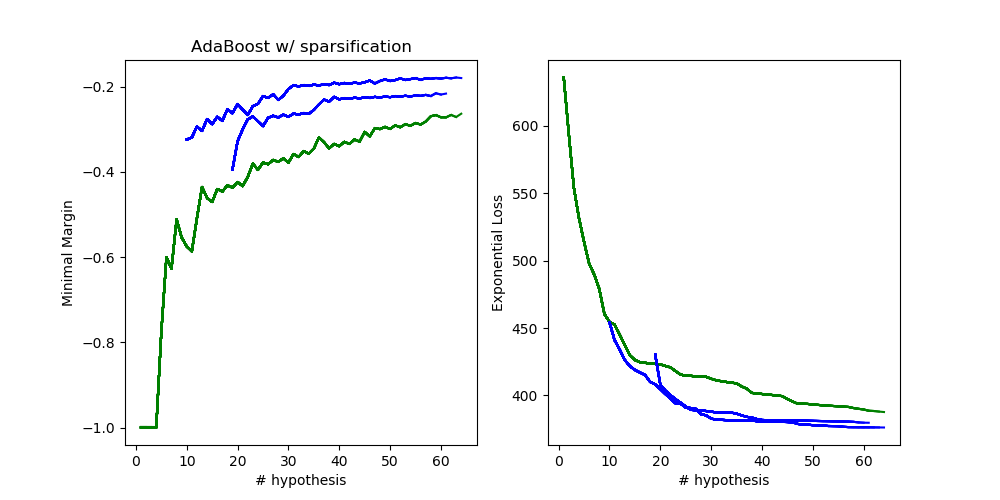

[===========================================================>]	DONE!	                                                   

Sparsify 10 gave margin: 	 -0.324264462295 	(-0.586684)
[==========================================================>]	DONE!	                                                    
Train 10 -> 64 gave margin: 	 -0.179984311979

Sparsify 19 gave margin: 	 -0.394315393843 	(-0.424019)
[======================================================>    ]	91.111%           

KeyboardInterrupt: 

In [11]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1
T = 64

ada = AdaBoost(visualize=True, print_progress=True)
ada.fit(X, y, T)
ada.sparsify(X, y, 10)

# Simple retrain

<IPython.core.display.Javascript object>


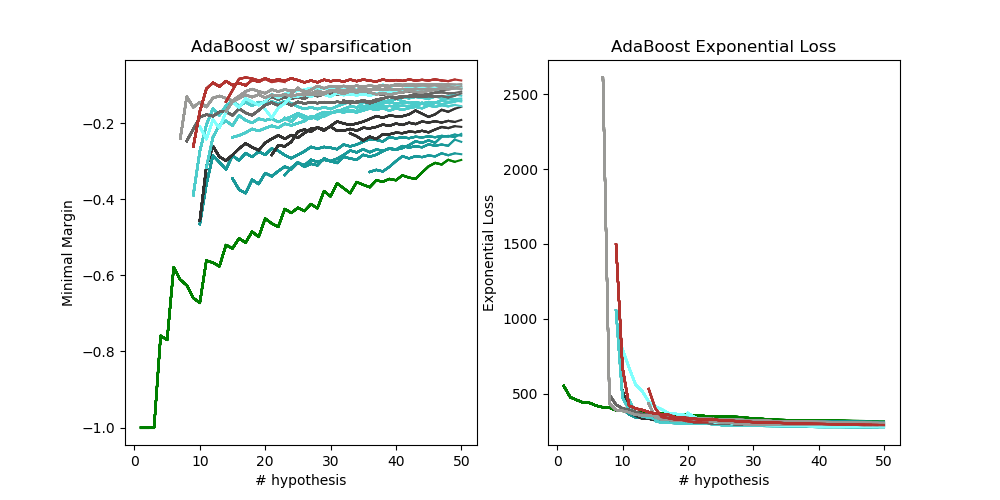

Round 0 -------------------------------------
#199999

Sparsify 10 gave margin: 	 -0.464796988669
Train 10 -> 50 gave margin: 	 -0.232557154782

Sparsify 15 gave margin: 	 -0.345171290288
Train 15 -> 50 gave margin: 	 -0.227726797752

Sparsify 23 gave margin: 	 -0.335492684397
Train 23 -> 50 gave margin: 	 -0.248622798813

Sparsify 36 gave margin: 	 -0.327725678337
Train 36 -> 50 gave margin: 	 -0.281171754886
Round 1 -------------------------------------
#333332

Sparsify 10 gave margin: 	 -0.456093361713
Train 10 -> 50 gave margin: 	 -0.156503932025

Sparsify 21 gave margin: 	 -0.282740063033
Train 21 -> 50 gave margin: 	 -0.191096319346

Sparsify 33 gave margin: 	 -0.226005215759
Train 33 -> 50 gave margin: 	 -0.209301347738
Round 2 -------------------------------------
#4ccccb

Sparsify 9 gave margin: 	 -0.388649423365
Train 9 -> 50 gave margin: 	 -0.127329034017

Sparsify 11 gave margin: 	 -0.316671874539
Train 11 -> 50 gave margin: 	 -0.142532977404

Sparsify 15 gave margin: 	 -0

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1

ada = AdaBoost(visualize=True)
ada.retrain(X, y, 10, max=50)